## Import everything:
Ignore the complaints that wget and/or Poppy are not installed.

In [8]:
import simmetis as sm
from astropy import units as u
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load the input and config files to create a simulator instance.
Adjust the paths to point to the files on your system.
Also make sure that the config file contains the correct SIM_DATA_DIR.

In [9]:
lms = sm.spectro.LMS("../../LMSsim/LINE_3D_013.fits", "metis_spectro_LMS.config")

Source file  ../../LMSsim/LINE_3D_013.fits
201 x 201 pixels, 251 spectral channels
image pixscale: [4.01736511 4.01736511] mas per pixel
BUNIT: JY/PIXEL
Pixel area is 1.6139222426878185e-05 arcsec2
CTYPES: ['RA---SIN', 'DEC--SIN', 'FREQ']
Wavelengths: [4.79232483 4.79233122 4.79233761] um ... 4.793923642827597 um
restfrq: 62546358407090.0
restwav: 0.0
Source velocities (WCS): -49991.66226419067 m / s ... 50008.34051741877 m / s
new naxis3: 67
middle v: 8.339126614049746 m / s
Detector velocities: (67,) -49491.66087338595 ... 49508.33912661405
Reading config  metis_spectro_LMS.config
Pixel scale  8.200000000000001  mas/pixel
Filter =  ../data/TC_filter_open.dat


## Simulate what happens to the data cube on the way through the atmosphere, the telescope, and METIS:
This will take a while...

Do not skip any of the steps or change the order!

-----Transmission and Emission-----
Plotting pixel [111,100] from source cube


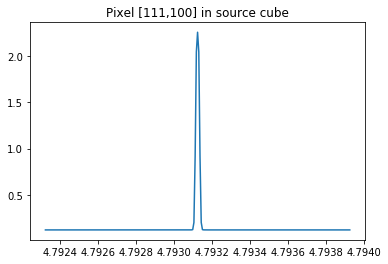

Reading  ../data/skycal_R308296_best_conditions.fits
Index skytran to src-wave: 483105 ... 483207
Plotting sky transmission in source wavelength range...
Steaming up optical train
Plotting SimMetis-transmission in source wavelength range...


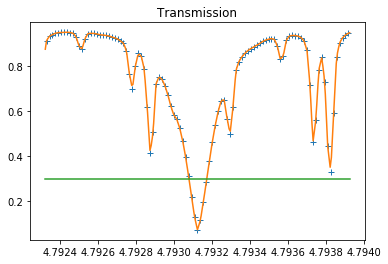

Plotting pixel [111,100] from transmitted cube


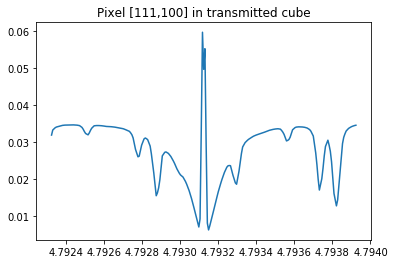

Pix_res:  0.0082
Mirror area:  1037.3460402337157 [m^2]
Plotting atmospheric & mirror emission...


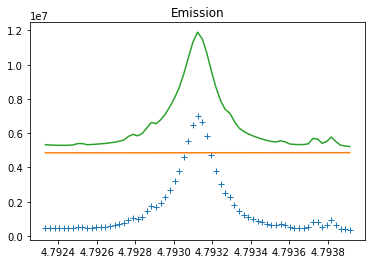

-----Convolution with PSF-----
image pixscale from WCS: [4.01736511 4.01736511] mas / pixel
Reading PSF ../data/PSF_SCAO_9mag_06seeing.fits
PSF for 3.8um is extension 2
PSF pixel scale is 7.65457 mas/pix @ 3.8 um, (1024, 1024) pixels
PSF pixel scale is 9.655080079899458 mas/pix @ 4.7931241472242 um,
Scale factor 2.4033364694476194
scale_image: old shape = (1024, 1024)
scale_image: new shape = (2460, 2460)
Normalizing PSF by factor 1115203631483117.5
Cropping PSF to [ 1029 : 1432 , 1029 : 1432 ]
Convolving with PSF...
251 250 249 248 247 246 245 244 243 242 241 240 239 238 237 236 235 234 233 232 231 230 229 228 227 226 225 224 223 222 221 220 219 218 217 216 215 214 213 212 211 210 209 208 207 206 205 204 203 202 201 200 199 198 197 196 195 194 193 192 191 190 189 188 187 186 185 184 183 182 181 180 179 178 177 176 175 174 173 172 171 170 169 168 167 166 165 164 163 162 161 160 159 158 157 156 155 154 153 152 151 150 149 148 147 146 145 144 143 142 141 140 139 138 137 136 135 134 133 1

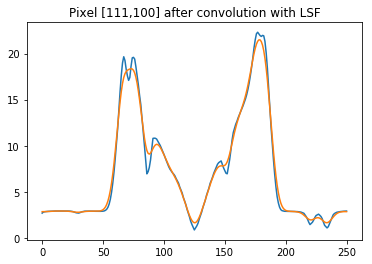


ScaleToDetector: naxis = 201 201 67
image pixscale from WCS: [4.01736511 4.01736511] mas /pixel
Scale factor: [0.48992257 0.48992257]
99 99
ScaleToDetector: new shape = (67, 99, 99)


In [10]:
lms.transmission_emission(conditions='best', plot=True)
lms.convolve_psf("PSF_SCAO_9mag_06seeing.fits", plot=True)
lms.convolve_lsf(plot=True)
lms.scale_to_detector()

## Compute the output cube for a total integration time of 60 seconds:

Source peak: 1460834280581.7346 ph / (arcsec2 s um)
(67, 99, 99)
Wavelength grid: (67,)
Background max: 11892645.326646293 ph / (s um)
d_lambda 2.401661485426695e-05 um
Pixel area 6.724000000000001e-05 arcsec2
peak pos: (47, 49, 50)
Source peak: 2359.0679475648258 ph / s
Background:  285.62108240846175 ph / s


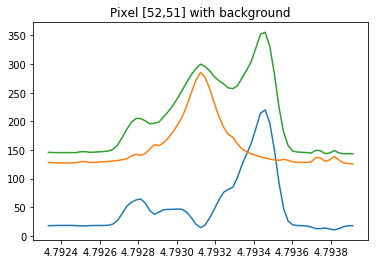

Peak 2494.9164872717784 ph / s , using DIT 32.06520154407291 s
Peak in one DIT 80000.0 ph
Total integration time 60.0 s => NDIT = 2.0


In [11]:
result = lms.compute_snr(60.*u.s)

#### The result is an HDU object, i.e. you can write it to a FITS file, or access its data and header:

In [12]:
result.writeto("Test_output.fits", overwrite=True)
cube = result.data
cube.shape
print(repr(result.header))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   99                                                  
NAXIS2  =                   99                                                  
NAXIS3  =                   67                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
OBJECT  = 'ProDiMo Model'                                                       
BTYPE   = 'Intensity'                                                           
BUNIT   = 'e/pixel '                                                            
CTYPE1  = 'RA---SIN'           / Right ascension, orthographic/synthesis project
CUNIT1  = 'deg     '        

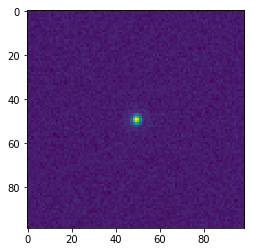

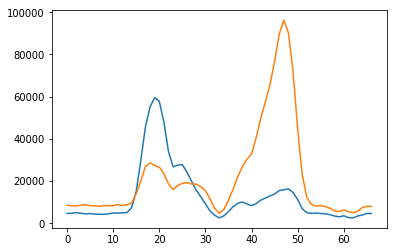

In [13]:
plt.figure()
plt.imshow(cube[33,:,:])

plt.figure()
plt.plot(cube[:,50,47])
plt.plot(cube[:,50,51])

## The last simulation step can be repeated with a different integration time:

Source peak: 1460834280581.7346 ph / (arcsec2 s um)
(67, 99, 99)
Wavelength grid: (67,)
Background max: 11892645.326646293 ph / (s um)
d_lambda 2.401661485426695e-05 um
Pixel area 6.724000000000001e-05 arcsec2
peak pos: (47, 49, 50)
Source peak: 2359.0679475648258 ph / s
Background:  285.62108240846175 ph / s


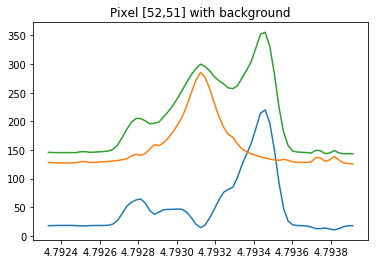

Peak 2494.9164872717784 ph / s , using DIT 32.06520154407291 s
Peak in one DIT 80000.0 ph
Total integration time 600.0 s => NDIT = 19.0


In [14]:
result = lms.compute_snr(600.*u.s)

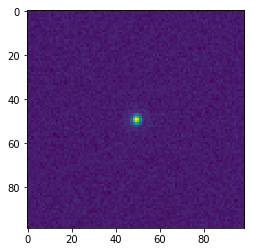

In [16]:
plt.figure()
plt.imshow(cube[33,:,:])
